In [2]:
import pandas as pd
import datetime as date
import time
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from numpy import array
from keras.models import load_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [4]:
def inverse_MinMax(df, df_inverse, col_pred, col_inverse):
    df_aux = df.copy()
    df_aux[col_pred] = (df_aux[col_pred]*df_inverse[col_inverse][1])+df_inverse[col_inverse][0]
    return df_aux

In [5]:
def pred_for_inverse(pred, X, Y):
    array_aux = [[0]]*Y.shape[1]
    c=0
    for i in pred[0]:
        a = [0]*X.shape[2]
        a[0] = i
        array_aux[c] = a
        c+=1
    return array_aux

In [6]:
def teste_modelo_3feat (modelo, TrainX, TrainY, TestX, TestY, scaler_used, df_original):
    dict_global = {} 
    for i in range(0,testX.shape[0]):
        x_input = array(TestX[i].reshape((1, TestX.shape[1], TestX.shape[2])))
        prediction = modelo.predict(x_input)
        predction_for_inv = pred_for_inverse(prediction, TrainX, TrainY)
        Pred_inversed = scaler_used.inverse_transform(predction_for_inv)
        pred_inverse = pd.DataFrame()
        pred_inverse = pd.DataFrame(Pred_inversed)
        pred_inverse = pred_inverse.rename(columns={0:'PLD - Predito'}).drop(columns={1,2})
        pred_inverse = pred_inverse.set_index(df_original[TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i].index)
        df_comp = pred_inverse.join(df_original['SE - PLD Médio (R$/MWh)'][TestX.shape[1]+i:TestX.shape[1]+TestY.shape[1]+i])
        col_pred, col_real = df_comp.columns[0], df_comp.columns[1]
        aval = avaliacao(df_comp, col_pred, col_real)
        dict_info = {'mae':aval[0], 'mape':aval[1], 'rmse':aval[2]}
        dict_append = {'df':aval[3], 'info':dict_info }
        dict_global[i+1] = dict_append
    return dict_global

In [52]:
def avaliacao(df_aux, col_pred, col_real):    
    df = df_aux.copy()
    df['PE'] = abs(df[col_pred]-df[col_real])/df[col_real]
    df['AE'] = abs(df[col_pred]-df[col_real])
    df['SE'] = (df[col_pred]-df[col_real])*(df[col_pred]-df[col_real])
    mae = df['AE'].mean()
    mape = df['PE'].mean()
    rmse = sqrt(float(df['SE'].mean()))
    print('MAE: ',mae)
    print('MAPE: ',mape)
    print('RMSE: ',rmse)
    return mae, mape, rmse, df

________________________________________________________________________________________________________________________

# Leitura Dados

## PLD

In [7]:
df_final_PLD =  pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\PLD_2018_2021_diario.xlsx')

In [8]:
df_final_PLD_2 = df_final_PLD.copy()
df_final_PLD_2['Data'] = pd.to_datetime(df_final_PLD_2['Data'])
df_final_PLD_2 = df_final_PLD_2.set_index('Data')

________________________________________________________________________________________________________________________

## ENA por Subsistema

In [9]:
df_final_ENASub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_ENA_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\ENA_Total_2018_2021_diario.xlsx', index_col = 'Data')

In [11]:
df_ecolhido_ena = df_ENA_total.drop(columns = 'ENA Armaz. (MWm)')


________________________________________________________________________________________________________________________

## EAR por Subsistema

In [12]:
df_final_EARSub = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_EAR_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\EAR_Total_2018_2021_diario.xlsx', index_col = 'Data')

________________________________________________________________________________________________________________________

## Carga diária Energia

In [14]:
df_final_Carga = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Sub_2018_2021_diario.xlsx', index_col = 'Data')
df_Carga_total = pd.read_excel(r'C:\Users\pablo\OneDrive\Documents\AAA_TCC\Dados Tratados\Carga_Total_2018_2021_diario.xlsx', index_col = 'Data')

________________________________________________________________________________________________________________________

# Junção Variáveis

In [15]:
def JoinVar (df1, df2, df3, df4, df5, df6, df7):
    lista = [df2, df3, df4, df5, df6, df7]
    df_final = df1
    for i in lista:
        df_final = df_final.join(i)
    return df_final

In [19]:
df_var = JoinVar (df_final_PLD_2, df_final_ENASub, df_final_EARSub, df_final_Carga, df_Carga_total, df_ENA_total, df_EAR_total)
df_var.columns

Index(['SE - PLD Médio (R$/MWh)', 'S - PLD Médio (R$/MWh)',
       'NE - PLD Médio (R$/MWh)', 'N - PLD Médio (R$/MWh)',
       'SE - ENA Bruta (MWm)', 'SE - ENA Bruta (%)',
       'SE - ENA Bruta Armaz. (MWm)', 'SE - ENA Armaz. (%)',
       'S - ENA Bruta (MWm)', 'S - ENA Bruta (%)',
       'S - ENA Bruta Armaz. (MWm)', 'S - ENA Armaz. (%)',
       'NE - ENA Bruta (MWm)', 'NE - ENA Bruta (%)',
       'NE - ENA Bruta Armaz. (MWm)', 'NE - ENA Armaz. (%)',
       'N - ENA Bruta (MWm)', 'N - ENA Bruta (%)',
       'N - ENA Bruta Armaz. (MWm)', 'N - ENA Armaz. (%)', 'SE - EAR Máx.',
       'SE - EAR Verif. (MWmês)', 'SE - EAR Verif (%)', 'S - EAR Máx.',
       'S - EAR Verif. (MWmês)', 'S - EAR Verif (%)', 'NE - EAR Máx.',
       'NE - EAR Verif. (MWmês)', 'NE - EAR Verif (%)', 'N - EAR Máx.',
       'N - EAR Verif. (MWmês)', 'N - EAR Verif (%)', 'SE - Carga (MWm)',
       'S - Carga (MWm)', 'NE - Carga (MWm)', 'N - Carga (MWm)', 'Carga (MWm)',
       'Media Móvel 7', 'ENA Bruta (MWm)', 'EN

________________________________________________________________________________________________________________________

# Escolha Variáveis

In [20]:
sel = ['S - PLD Médio (R$/MWh)', 'NE - PLD Médio (R$/MWh)',
       'N - PLD Médio (R$/MWh)','SE - ENA Bruta (%)','SE - ENA Armaz. (%)','SE - EAR Verif (%)',
     'Carga (MWm)','ENA Bruta (MWm)','ENA Armaz. (MWm)','EAR Verif. Total (%)']
df_escolhido = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel:
    df_escolhido = df_escolhido.join(df_var[i])
df_escolhido

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (%),SE - ENA Armaz. (%),SE - EAR Verif (%),Carga (MWm),ENA Bruta (MWm),ENA Armaz. (MWm),EAR Verif. Total (%)
Data,,,,,,,,,,,
2018-05-02,214.646667,214.662500,190.621250,178.925000,88.275002,76.983398,43.900200,65381.392583,58970.907959,49664.467773,0.458910
2018-05-03,168.905833,168.934167,120.433333,120.406667,86.215599,78.004204,43.828999,66938.248333,57479.126953,49444.537354,0.457995
2018-05-04,225.345833,225.367500,114.855000,114.823333,84.744102,77.204201,43.728298,67031.116625,56654.833008,48306.832764,0.456794
2018-05-05,275.532500,275.570833,123.934583,123.894583,83.725899,75.946098,43.696999,61356.033375,55804.570068,46507.023682,0.456325
2018-05-06,155.334583,155.357917,77.849167,77.827500,82.473701,71.800201,43.691299,55092.441625,54926.362549,44621.667969,0.456129
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,68.084167,68.085000,68.037917,68.037083,110.278900,96.091698,24.684700,69066.145500,90544.118652,79667.989746,0.314215
2021-12-28,68.389167,68.389167,68.353333,68.352500,110.417297,96.244102,24.862000,69954.770708,91952.735107,80709.130127,0.317530
2021-12-29,66.705417,66.705417,66.067500,65.970833,111.535103,96.548798,25.012400,69973.731792,94431.855835,82476.878052,0.320648


In [21]:
corr = df_escolhido.corr()

In [22]:
corr.style.background_gradient(cmap='coolwarm')

,SE - PLD Médio (R$/MWh),S - PLD Médio (R$/MWh),NE - PLD Médio (R$/MWh),N - PLD Médio (R$/MWh),SE - ENA Bruta (%),SE - ENA Armaz. (%),SE - EAR Verif (%),Carga (MWm),ENA Bruta (MWm),ENA Armaz. (MWm),EAR Verif. Total (%)
SE - PLD Médio (R$/MWh),1.000000,0.994705,0.909312,0.884002,-0.491654,-0.455538,-0.447201,0.137828,-0.519506,-0.512795,-0.461686
S - PLD Médio (R$/MWh),0.994705,1.000000,0.904744,0.878021,-0.480984,-0.447259,-0.435999,0.148357,-0.494213,-0.488340,-0.453173
NE - PLD Médio (R$/MWh),0.909312,0.904744,1.000000,0.904331,-0.389409,-0.334980,-0.439546,0.098127,-0.511988,-0.497719,-0.448995
N - PLD Médio (R$/MWh),0.884002,0.878021,0.904331,1.000000,-0.445260,-0.372311,-0.455916,0.051660,-0.642517,-0.627355,-0.450455
SE - ENA Bruta (%),-0.491654,-0.480984,-0.389409,-0.445260,1.000000,0.985026,0.156349,-0.123014,0.511125,0.531945,0.086538
SE - ENA Armaz. (%),-0.455538,-0.447259,-0.334980,-0.372311,0.985026,1.000000,0.123114,-0.134188,0.402566,0.435377,0.056264
SE - EAR Verif (%),-0.447201,-0.435999,-0.439546,-0.455916,0.156349,0.123114,1.000000,-0.485989,0.213751,0.151892,0.976951
Carga (MWm),0.137828,0.148357,0.098127,0.051660,-0.123014,-0.134188,-0.485989,1.000000,0.167736,0.202749,-0.442603
ENA Bruta (MWm),-0.519506,-0.494213,-0.511988,-0.642517,0.511125,0.402566,0.213751,0.167736,1.000000,0.990135,0.174776
ENA Armaz. (MWm),-0.512795,-0.488340,-0.497719,-0.627355,0.531945,0.435377,0.151892,0.202749,0.990135,1.000000,0.110220


In [23]:
sel_2 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)','Carga (MWm)']
df_4_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_2:
    df_4_features = df_4_features.join(df_var[i])
df_4_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [24]:
df_escolhido_2 = df_4_features
df_escolhido_2

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês),Carga (MWm)
Data,,,,
2018-05-02,214.646667,58970.907959,132567.533203,65381.392583
2018-05-03,168.905833,57479.126953,132303.383789,66938.248333
2018-05-04,225.345833,56654.833008,131956.226563,67031.116625
2018-05-05,275.532500,55804.570068,131820.939453,61356.033375
2018-05-06,155.334583,54926.362549,131764.245117,55092.441625
...,...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000,69066.145500
2021-12-28,68.389167,91952.735107,92468.512207,69954.770708
2021-12-29,66.705417,94431.855835,93376.443359,69973.731792


In [25]:
sel_3 = ['ENA Bruta (MWm)','EAR Verif. (MWmês)']
df_3_features = pd.DataFrame( {'SE - PLD Médio (R$/MWh)':df_var['SE - PLD Médio (R$/MWh)']})
for i in sel_3:
    df_3_features = df_3_features.join(df_var[i])
df_3_features

,SE - PLD Médio (R$/MWh),ENA Bruta (MWm),EAR Verif. (MWmês)
Data,,,
2018-05-02,214.646667,58970.907959,132567.533203
2018-05-03,168.905833,57479.126953,132303.383789
2018-05-04,225.345833,56654.833008,131956.226563
2018-05-05,275.532500,55804.570068,131820.939453
2018-05-06,155.334583,54926.362549,131764.245117
...,...,...,...
2021-12-27,68.084167,90544.118652,91503.250000
2021-12-28,68.389167,91952.735107,92468.512207
2021-12-29,66.705417,94431.855835,93376.443359


________________________________________________________________________________________________________________________

# Arima com transformação - PLD

In [37]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [38]:
ts = pd.DataFrame()
ts['SE - PLD Médio (R$/MWh)'] = df_var['SE - PLD Médio (R$/MWh)']

In [39]:
df = ts.copy()
df = df.rename(columns={'SE - PLD Médio (R$/MWh)':'value'}).reset_index()

In [40]:
df['logvalue'] = np.log(df['value'])

In [41]:
df['difflog'] = df.logvalue.diff()

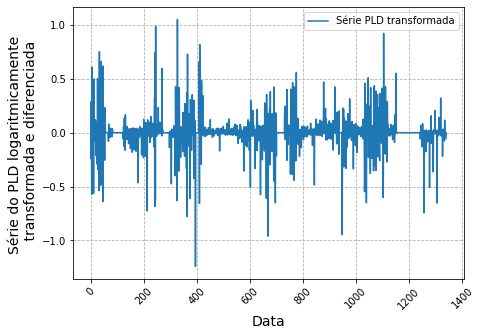

In [42]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df['difflog'], label = 'Série PLD transformada')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Série do PLD logaritmicamente \n transformada e diferenciada', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\PLD_transformado',bbox_inches='tight')

In [43]:
df_mod = df.set_index('Data')

In [45]:
df_sel = df['difflog'].dropna()
df_mod = df_sel.reset_index().drop(columns={'index'})

In [46]:
point = 1315
train = df_mod[:point]
test = df_mod[point:]
test_index = df_sel[point:]

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


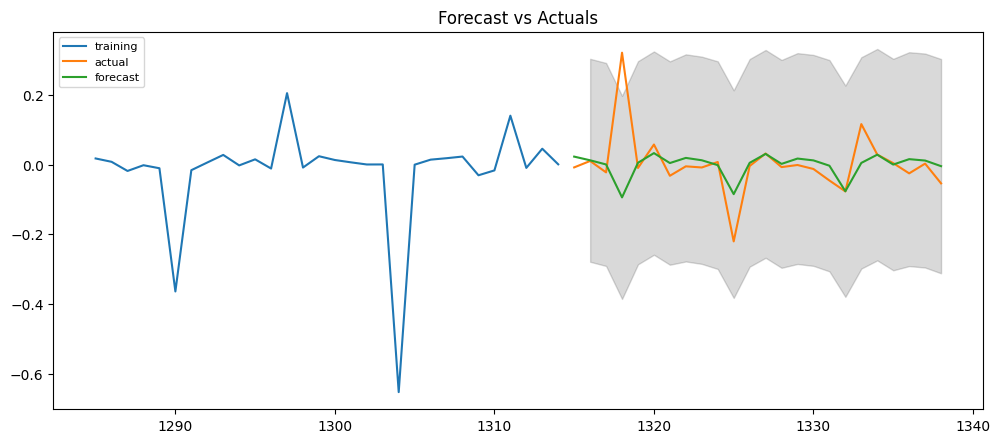

In [47]:
# Build Model
model = ARIMA(train, order=(7, 1, 7))  
fitted = model.fit()  

# Forecast
n_steps = test.shape[0]
fc = fitted.forecast(n_steps, alpha=0.05)  # 95% conf

# get forecast with updated
forecast = fitted.get_forecast(test.shape[0])

# Mean forecast
yhat = forecast.predicted_mean

# Confidence intervals of forecasts
conf = forecast.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.loc[:, 'lower difflog'], index=test_index.index)
upper_series = pd.Series(conf.loc[:, 'upper difflog'], index=test_index.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-30:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [48]:
fc_reindex = fc_series.reset_index()
fc_reindex['index'] = fc_reindex['index']+1
fc_reindex = fc_reindex.set_index('index')


In [49]:
df_fc = df.join(fc_reindex)
df_fc = df_fc.set_index('Data')

In [50]:
pred = df_fc['difflog'][:min(df_fc['predicted_mean'].dropna().index)].iloc[:-1].append(df_fc['predicted_mean'].dropna())
df_fc['pred for reverse'] = pred
df_fc['pred reverse diff'] = np.concatenate(([df.logvalue[0]], pred.dropna())).cumsum()
df_fc

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff
Data,,,,,,
2018-05-02,214.646667,5.368993,NaN,NaN,NaN,5.368993
2018-05-03,168.905833,5.129341,-0.239652,NaN,-0.239652,5.129341
2018-05-04,225.345833,5.417636,0.288295,NaN,0.288295,5.417636
2018-05-05,275.532500,5.618706,0.201069,NaN,0.201069,5.618706
2018-05-06,155.334583,5.045581,-0.573124,NaN,-0.573124,5.045581
...,...,...,...,...,...,...
2021-12-27,68.084167,4.220745,0.029002,0.028775,0.028775,4.051125
2021-12-28,68.389167,4.225214,0.004470,0.000336,0.000336,4.051461
2021-12-29,66.705417,4.200286,-0.024928,0.015886,0.015886,4.067347


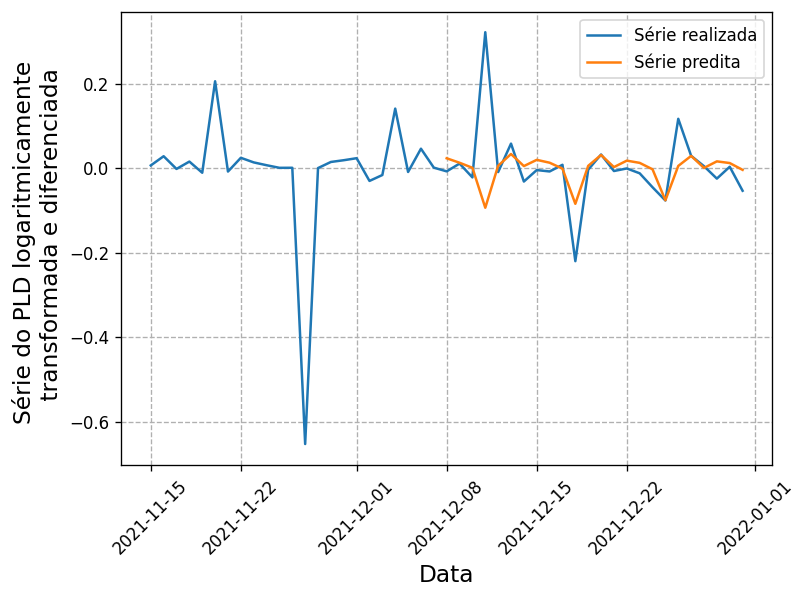

In [51]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_fc['difflog']['2021-11-15':], label = 'Série realizada')
plt.plot(df_fc['predicted_mean']['2021-11-15':], label = 'Série predita')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Série do PLD logaritmicamente \n transformada e diferenciada', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\PLD_transformad_arima',bbox_inches='tight')

In [53]:
df_fc['pred reverse diff'] = np.concatenate(([df.logvalue[0]], df_fc['pred for reverse'].dropna())).cumsum()
df_fc['pred reverselog'] = np.exp(df_fc['pred reverse diff'])
df_fc

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff,pred reverselog
Data,,,,,,,
2018-05-02,214.646667,5.368993,NaN,NaN,NaN,5.368993,214.646667
2018-05-03,168.905833,5.129341,-0.239652,NaN,-0.239652,5.129341,168.905833
2018-05-04,225.345833,5.417636,0.288295,NaN,0.288295,5.417636,225.345833
2018-05-05,275.532500,5.618706,0.201069,NaN,0.201069,5.618706,275.532500
2018-05-06,155.334583,5.045581,-0.573124,NaN,-0.573124,5.045581,155.334583
...,...,...,...,...,...,...,...
2021-12-27,68.084167,4.220745,0.029002,0.028775,0.028775,4.051125,57.462046
2021-12-28,68.389167,4.225214,0.004470,0.000336,0.000336,4.051461,57.481370
2021-12-29,66.705417,4.200286,-0.024928,0.015886,0.015886,4.067347,58.401803


In [54]:
df_esp_comp = df_fc['2021-12-08':]
df_esp_comp

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff,pred reverselog
Data,,,,,,,
2021-12-08,59.605417,4.087746,-0.007785,0.023174,0.023174,4.118705,61.479579
2021-12-09,60.243333,4.098392,0.010645,0.012625,0.012625,4.131330,62.260658
2021-12-10,58.927083,4.076301,-0.022091,0.000668,0.000668,4.131997,62.302245
2021-12-11,81.276250,4.397854,0.321553,-0.093899,-0.093899,4.038099,56.718399
2021-12-12,80.514583,4.388438,-0.009416,0.005541,0.005541,4.043639,57.033537
2021-12-13,85.313750,4.446336,0.057897,0.033261,0.033261,4.076901,58.962446
2021-12-14,82.639583,4.414489,-0.031847,0.004713,0.004713,4.081614,59.240985
2021-12-15,82.251250,4.409779,-0.004710,0.019480,0.019480,4.101094,60.406336
2021-12-16,81.594583,4.401763,-0.008016,0.012700,0.012700,4.113794,61.178381


In [56]:
df_esp = df_fc['2021-12-08':'2021-12-14']
df_esp

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff,pred reverselog
Data,,,,,,,
2021-12-08,59.605417,4.087746,-0.007785,0.023174,0.023174,4.118705,61.479579
2021-12-09,60.243333,4.098392,0.010645,0.012625,0.012625,4.131330,62.260658
2021-12-10,58.927083,4.076301,-0.022091,0.000668,0.000668,4.131997,62.302245
2021-12-11,81.276250,4.397854,0.321553,-0.093899,-0.093899,4.038099,56.718399
2021-12-12,80.514583,4.388438,-0.009416,0.005541,0.005541,4.043639,57.033537
2021-12-13,85.313750,4.446336,0.057897,0.033261,0.033261,4.076901,58.962446
2021-12-14,82.639583,4.414489,-0.031847,0.004713,0.004713,4.081614,59.240985


In [57]:
av_esp = avaliacao(df_esp, 'pred reverselog', 'value')

MAE:  15.007921241006676
MAPE:  0.18685880045811962
RMSE:  18.57535628061682


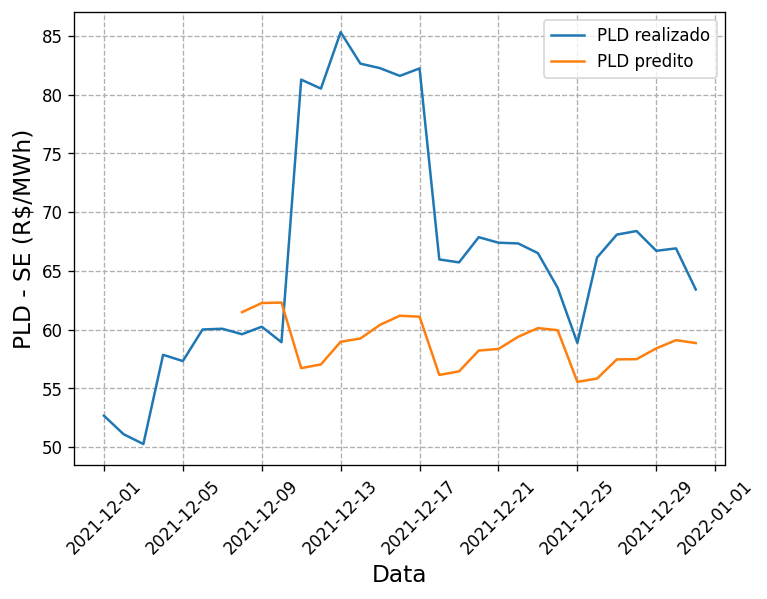

In [58]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_fc['value']['2021-12-01':], label = 'PLD realizado')
plt.plot(df_fc['pred reverselog']['2021-12-08':], label = 'PLD predito')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('PLD - SE (R$/MWh)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
#plt.show()
plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\Predicao_arima_original_PLD',bbox_inches='tight')

# Arima com transformação - EAR

In [59]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [60]:
ts = pd.DataFrame()
ts['EAR Verif. (MWmês)'] = df_var['EAR Verif. (MWmês)']

In [61]:
df = ts.copy()
df = df.rename(columns={'EAR Verif. (MWmês)':'value'}).reset_index()

In [62]:
df['logvalue'] = np.log(df['value'])

In [63]:
df['difflog'] = df.logvalue.diff()

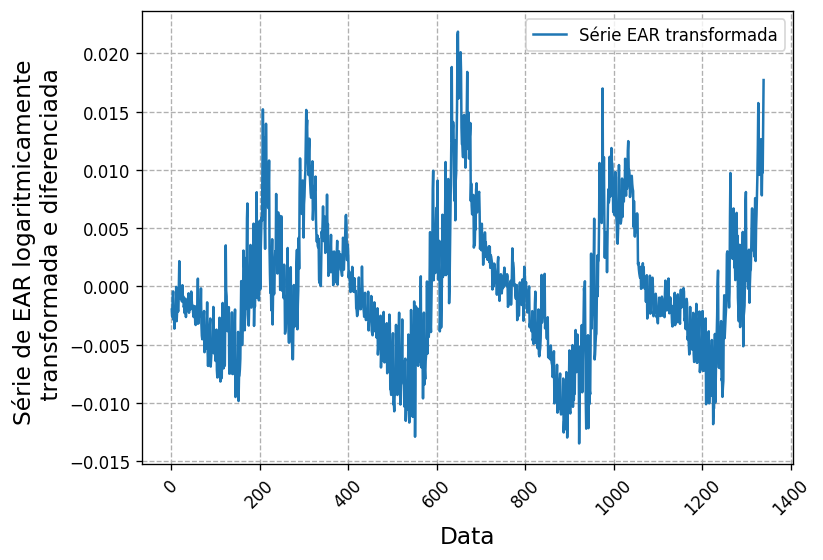

In [64]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df['difflog'], label = 'Série EAR transformada')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Série de EAR logaritmicamente \n transformada e diferenciada', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
#plt.show()
plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\EAR_transformada',bbox_inches='tight')

In [65]:
df_mod = df.set_index('Data')

In [67]:
df_sel = df['difflog'].dropna()
df_mod = df_sel.reset_index().drop(columns={'index'})

In [68]:
point = 1315
train = df_mod[:point]
test = df_mod[point:]
test_index = df_sel[point:]

In [69]:
test_index

1316    0.006118
1317    0.003887
1318    0.002567
1319    0.005692
1320    0.007574
1321    0.002176
1322    0.004940
1323    0.006184
1324    0.007939
1325    0.009493
1326    0.012093
1327    0.015732
1328    0.011416
1329    0.010694
1330    0.009568
1331    0.010532
1332    0.010236
1333    0.012631
1334    0.010401
1335    0.007806
1336    0.010494
1337    0.009771
1338    0.013692
1339    0.017706
Name: difflog, dtype: float64

C:\Users\pablo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


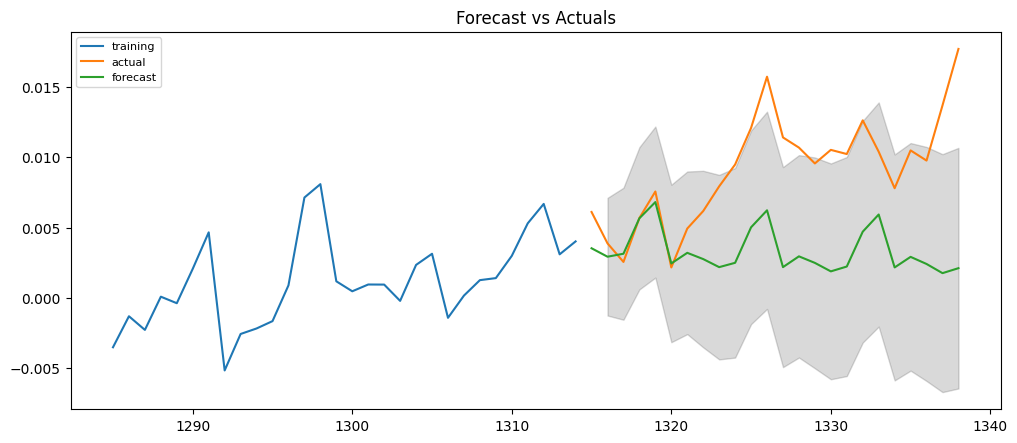

In [71]:
# Build Model
model = ARIMA(train, order=(7, 1, 7))  
fitted = model.fit()  

# Forecast
n_steps = test.shape[0]
fc = fitted.forecast(n_steps, alpha=0.05)  # 95% conf

# get forecast with updated
forecast = fitted.get_forecast(test.shape[0])

# Mean forecast
yhat = forecast.predicted_mean

# Confidence intervals of forecasts
conf = forecast.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.loc[:, 'lower difflog'], index=test_index.index)
upper_series = pd.Series(conf.loc[:, 'upper difflog'], index=test_index.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-30:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [72]:
fc_reindex = fc_series.reset_index()
fc_reindex['index'] = fc_reindex['index']+1
fc_reindex = fc_reindex.set_index('index')


In [73]:
df_fc = df.join(fc_reindex)
df_fc = df_fc.set_index('Data')

In [75]:
pred = df_fc['difflog'][:min(df_fc['predicted_mean'].dropna().index)].iloc[:-1].append(df_fc['predicted_mean'].dropna())
df_fc['pred for reverse'] = pred
df_fc['pred reverse diff'] = np.concatenate(([df.logvalue[0]], pred.dropna())).cumsum()


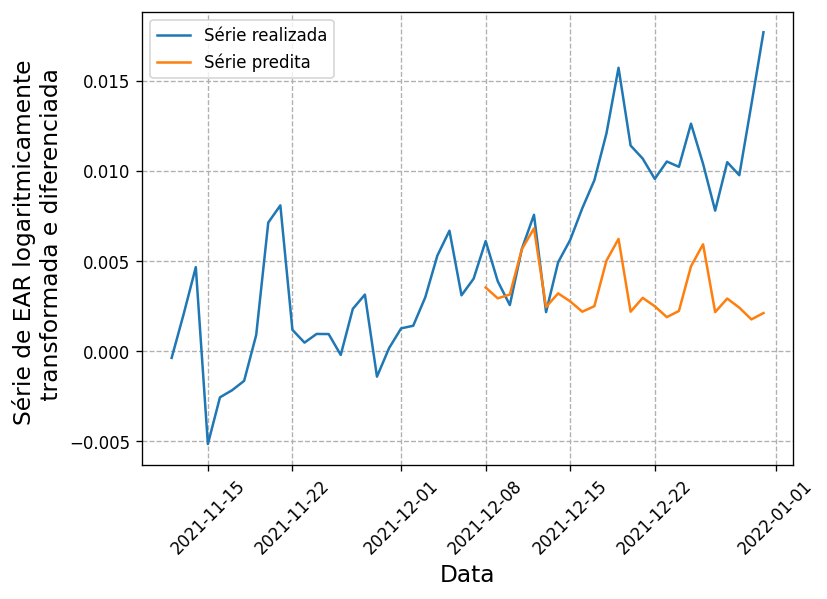

In [76]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_fc['difflog'][1290:], label = 'Série realizada')
plt.plot(df_fc['predicted_mean'][1290:], label = 'Série predita')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Série de EAR logaritmicamente \n transformada e diferenciada', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
#plt.show()
plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\EAR_trasformado_predito',bbox_inches='tight')

In [77]:
df_fc['pred reverse diff'] = np.concatenate(([df.logvalue[0]], df_fc['pred for reverse'].dropna())).cumsum()
df_fc['pred reverselog'] = np.exp(df_fc['pred reverse diff'])


In [78]:
df_esp_comp = df_fc['2021-12-08':]
df_esp_comp

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff,pred reverselog
Data,,,,,,,
2021-12-08,77852.341309,11.262569,0.006118,0.003539,0.003539,11.259990,77651.771791
2021-12-09,78155.549805,11.266456,0.003887,0.002940,0.002940,11.262929,77880.365482
2021-12-10,78356.454102,11.269024,0.002567,0.003150,0.003150,11.266080,78126.105164
2021-12-11,78803.708008,11.274715,0.005692,0.005673,0.005673,11.271752,78570.553439
2021-12-12,79402.808105,11.282289,0.007574,0.006822,0.006822,11.278574,79108.383993
2021-12-13,79575.745605,11.284465,0.002176,0.002460,0.002460,11.281034,79303.230726
2021-12-14,79969.857422,11.289405,0.004940,0.003215,0.003215,11.284249,79558.586900
2021-12-15,80465.919434,11.295589,0.006184,0.002770,0.002770,11.287019,79779.285483
2021-12-16,81107.298828,11.303528,0.007939,0.002198,0.002198,11.289217,79954.806855


In [79]:
df_esp = df_fc['2021-12-08':'2021-12-14']
df_esp

,value,logvalue,difflog,predicted_mean,pred for reverse,pred reverse diff,pred reverselog
Data,,,,,,,
2021-12-08,77852.341309,11.262569,0.006118,0.003539,0.003539,11.259990,77651.771791
2021-12-09,78155.549805,11.266456,0.003887,0.002940,0.002940,11.262929,77880.365482
2021-12-10,78356.454102,11.269024,0.002567,0.003150,0.003150,11.266080,78126.105164
2021-12-11,78803.708008,11.274715,0.005692,0.005673,0.005673,11.271752,78570.553439
2021-12-12,79402.808105,11.282289,0.007574,0.006822,0.006822,11.278574,79108.383993
2021-12-13,79575.745605,11.284465,0.002176,0.002460,0.002460,11.281034,79303.230726
2021-12-14,79969.857422,11.289405,0.004940,0.003215,0.003215,11.284249,79558.586900


In [80]:
av_esp = avaliacao(df_esp, 'pred reverselog', 'value')

MAE:  273.92383730620867
MAPE:  0.0034672990536614512
RMSE:  281.1886983915464


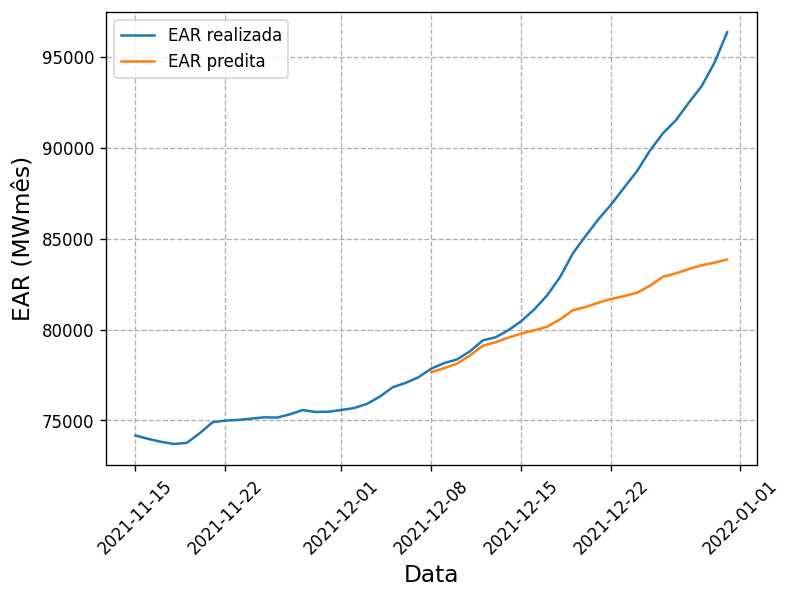

In [81]:
plt.figure(figsize=(7, 5)) # REGULAR O TAMANHO AQUI
plt.plot(df_fc['value']['2021-11-15':], label = 'EAR realizada')
plt.plot(df_fc['pred reverselog']['2021-12-08':], label = 'EAR predita')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=14)
plt.ylabel('EAR (MWmês)', fontsize=14)
plt.grid(linestyle='--') # Para colocar o grid
#plt.title('Comparação entre PLD realizado e predito', fontsize=16) # Titulo
plt.show()
#plt.savefig(r'C:\Users\pablo\OneDrive\Pictures\AAA TCC\Arima\EAR_original_predita',bbox_inches='tight')